### Analyzing London crime statistics

#### Creating a Spark session

* Encapsulates SparkContext and the SQLContext within it

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Analyzing London crime data") \
    .getOrCreate()

#### Reading external data as a dataframe

In [2]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("../datasets/london_crime_by_lsoa.csv")

In [3]:
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [4]:
data.count()

13490604

In [5]:
data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



#### Cleaning data
* Drop rows which do not have valid values
* Drop columns which we do not use in our analysis

In [6]:
data.dropna()

DataFrame[lsoa_code: string, borough: string, major_category: string, minor_category: string, value: string, year: string, month: string]

In [7]:
data = data.drop("lsoa_code")

data.show(5)

+----------+--------------------+--------------------+-----+----+-----+
|   borough|      major_category|      minor_category|value|year|month|
+----------+--------------------+--------------------+-----+----+-----+
|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



#### Boroughs included in the report

In [8]:
total_boroughs = data.select('borough')\
                     .distinct()\
        
total_boroughs.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [9]:
total_boroughs.count()

33

In [10]:
hackney_data = data.filter(data['borough'] == "Hackney")

hackney_data.show(5)

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [11]:
data_2015_2016 = data.filter(data['year'].isin(["2015", "2016"]))

data_2015_2016.sample(fraction=0.1).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|            Hounslow|Violence Against ...|        Wounding/GBH|    2|2015|    8|
|             Croydon|  Theft and Handling|Motor Vehicle Int...|    0|2016|    3|
|             Lambeth|               Drugs|    Drug Trafficking|    0|2015|    9|
|       Tower Hamlets|            Burglary|Burglary in a Dwe...|    0|2016|    3|
|              Bexley|  Theft and Handling|  Other Theft Person|    0|2016|    8|
|Kensington and Ch...|  Theft and Handling|         Other Theft|    2|2016|    9|
|              Harrow|               Drugs| Possession Of Drugs|    0|2016|   11|
|               Brent|  Theft and Handling|  Other Theft Person|    1|2016|   12|
|               

In [12]:
data_2014_onwards = data.filter(data['year'] >= 2014 )

data_2014_onwards.sample(fraction=0.1).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|            Hounslow|     Criminal Damage|Criminal Damage T...|    0|2015|    2|
|             Croydon|  Theft and Handling|         Other Theft|    1|2014|    5|
|Hammersmith and F...|             Robbery|   Business Property|    0|2014|    9|
|              Ealing|             Robbery|   Personal Property|    0|2014|    9|
|             Enfield|Violence Against ...|      Other violence|    1|2014|    9|
|Kensington and Ch...|  Theft and Handling|         Other Theft|    2|2016|    9|
|              Ealing|  Theft and Handling|Theft/Taking Of M...|    0|2016|    1|
|             Lambeth|     Sexual Offences|                Rape|    0|2014|    3|
|              Ealing|Violence Against ...|        Wounding/GBH|    0|2015|   12|
|      Waltham F

#### Total crime per borough

In [13]:
borough_crime_count = data.groupBy('borough')\
                          .count()
    
borough_crime_count.show(5)

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|602100|
|          Wandsworth|498636|
|              Bexley|385668|
|             Lambeth|519048|
|Barking and Dagenham|311040|
+--------------------+------+
only showing top 5 rows



#### Total convictions per borough

In [14]:
borough_conviction_sum = data.groupBy('borough')\
                             .agg({"value":"sum"})

borough_conviction_sum.show(5)

+--------------------+----------+
|             borough|sum(value)|
+--------------------+----------+
|             Croydon|  260294.0|
|          Wandsworth|  204741.0|
|              Bexley|  114136.0|
|             Lambeth|  292178.0|
|Barking and Dagenham|  149447.0|
+--------------------+----------+
only showing top 5 rows



In [15]:
borough_conviction_sum = data.groupBy('borough')\
                             .agg({"value":"sum"})\
                             .withColumnRenamed("sum(value)","convictions")

borough_conviction_sum.show(5)

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|   260294.0|
|          Wandsworth|   204741.0|
|              Bexley|   114136.0|
|             Lambeth|   292178.0|
|Barking and Dagenham|   149447.0|
+--------------------+-----------+
only showing top 5 rows



#### Per-borough convictions expressed in percentage

Total convictions

In [16]:
total_borough_convictions = borough_conviction_sum.agg({"convictions":"sum"})

total_borough_convictions.show()

+----------------+
|sum(convictions)|
+----------------+
|       6447758.0|
+----------------+



Extracting total convictions into a variable

In [17]:
total_convictions = total_borough_convictions.collect()[0][0]

A new column which contains the % convictions for each borough

In [18]:
import pyspark.sql.functions as func

In [19]:
borough_percentage_contribution = borough_conviction_sum.withColumn(
    "% contribution",
    func.round(borough_conviction_sum.convictions / total_convictions * 100, 2))

borough_percentage_contribution.printSchema()

root
 |-- borough: string (nullable = true)
 |-- convictions: double (nullable = true)
 |-- % contribution: double (nullable = true)



In [20]:
borough_percentage_contribution.orderBy(borough_percentage_contribution[2].desc())\
                               .show(10)

+-------------+-----------+--------------+
|      borough|convictions|% contribution|
+-------------+-----------+--------------+
|  Westminster|   455028.0|          7.06|
|      Lambeth|   292178.0|          4.53|
|    Southwark|   278809.0|          4.32|
|       Camden|   275147.0|          4.27|
|       Newham|   262024.0|          4.06|
|      Croydon|   260294.0|          4.04|
|       Ealing|   251562.0|           3.9|
|    Islington|   230286.0|          3.57|
|Tower Hamlets|   228613.0|          3.55|
|        Brent|   227551.0|          3.53|
+-------------+-----------+--------------+
only showing top 10 rows



#### Convictions across months in a particular year

In [21]:
conviction_monthly = data.filter(data['year'] == 2014)\
                         .groupBy('month')\
                         .agg({"value":"sum"})\
                         .withColumnRenamed("sum(value)","convictions")

In [22]:
total_conviction_monthly = conviction_monthly.agg({"convictions":"sum"})\
                                             .collect()[0][0]

total_conviction_monthly = conviction_monthly\
    .withColumn("percent",
                func.round(conviction_monthly.convictions/total_conviction_monthly * 100, 2))
total_conviction_monthly.columns

['month', 'convictions', 'percent']

In [23]:
total_conviction_monthly.orderBy(total_conviction_monthly.percent.desc()).show()

+-----+-----------+-------+
|month|convictions|percent|
+-----+-----------+-------+
|   10|    60537.0|    8.9|
|   11|    59704.0|   8.78|
|    7|    58564.0|   8.61|
|    3|    57669.0|   8.48|
|   12|    57565.0|   8.46|
|    6|    57039.0|   8.39|
|    9|    56933.0|   8.37|
|    5|    56327.0|   8.28|
|    8|    55641.0|   8.18|
|    1|    55515.0|   8.16|
|    4|    53467.0|   7.86|
|    2|    51222.0|   7.53|
+-----+-----------+-------+



#### Most prevalant crimes

In [24]:
crimes_category = data.groupBy('major_category')\
                      .agg({"value":"sum"})\
                      .withColumnRenamed("sum(value)","convictions")

In [25]:
crimes_category.orderBy(crimes_category.convictions.desc()).show()

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|  Theft and Handling|  2661861.0|
|Violence Against ...|  1558081.0|
|            Burglary|   754293.0|
|     Criminal Damage|   630938.0|
|               Drugs|   470765.0|
|             Robbery|   258873.0|
|Other Notifiable ...|   106349.0|
|    Fraud or Forgery|     5325.0|
|     Sexual Offences|     1273.0|
+--------------------+-----------+



In [26]:
year_df = data.select('year')

In [27]:
year_df.agg({'year':'min'}).show()

+---------+
|min(year)|
+---------+
|     2008|
+---------+



In [28]:
year_df.agg({'year':'max'}).show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [29]:
year_df.describe().show()

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|         13490604|
|   mean|           2012.0|
| stddev|2.581988993167432|
|    min|             2008|
|    max|             2016|
+-------+-----------------+



In [34]:
data.crosstab('borough', 'major_category')\
    .select('borough_major_category', 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery')\
    .show()

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|   32400|32616|            5508|  27648|
|                Merton|   26784|29160|            5724|  23652|
|              Haringey|   31320|35424|           10368|  29484|
|         Tower Hamlets|   31104|37368|            5400|  28512|
|               Bromley|   42552|42336|            8532|  34668|
|               Enfield|   39528|44064|            9720|  35532|
|  Kingston upon Thames|   21168|22140|            3780|  15660|
|           Westminster|   27648|32616|            8748|  25056|
|  Richmond upon Thames|   24840|23004|            2808|  18468|
|              Lewisham|   36504|43740|           11016|  34884|
|                 Brent|   37368|46980|            9288|  34128|
|  Barking and Dagenham|   23760|26244|            7236|  22248|
|             Redbridge| 

#### Visualizing the data

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Distribution of crime across boroughs in a particular year

In [92]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy('borough')\
                         .agg({'value':'sum'})\
                         .withColumnRenamed("sum(value)","convictions")
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
  
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + year, fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

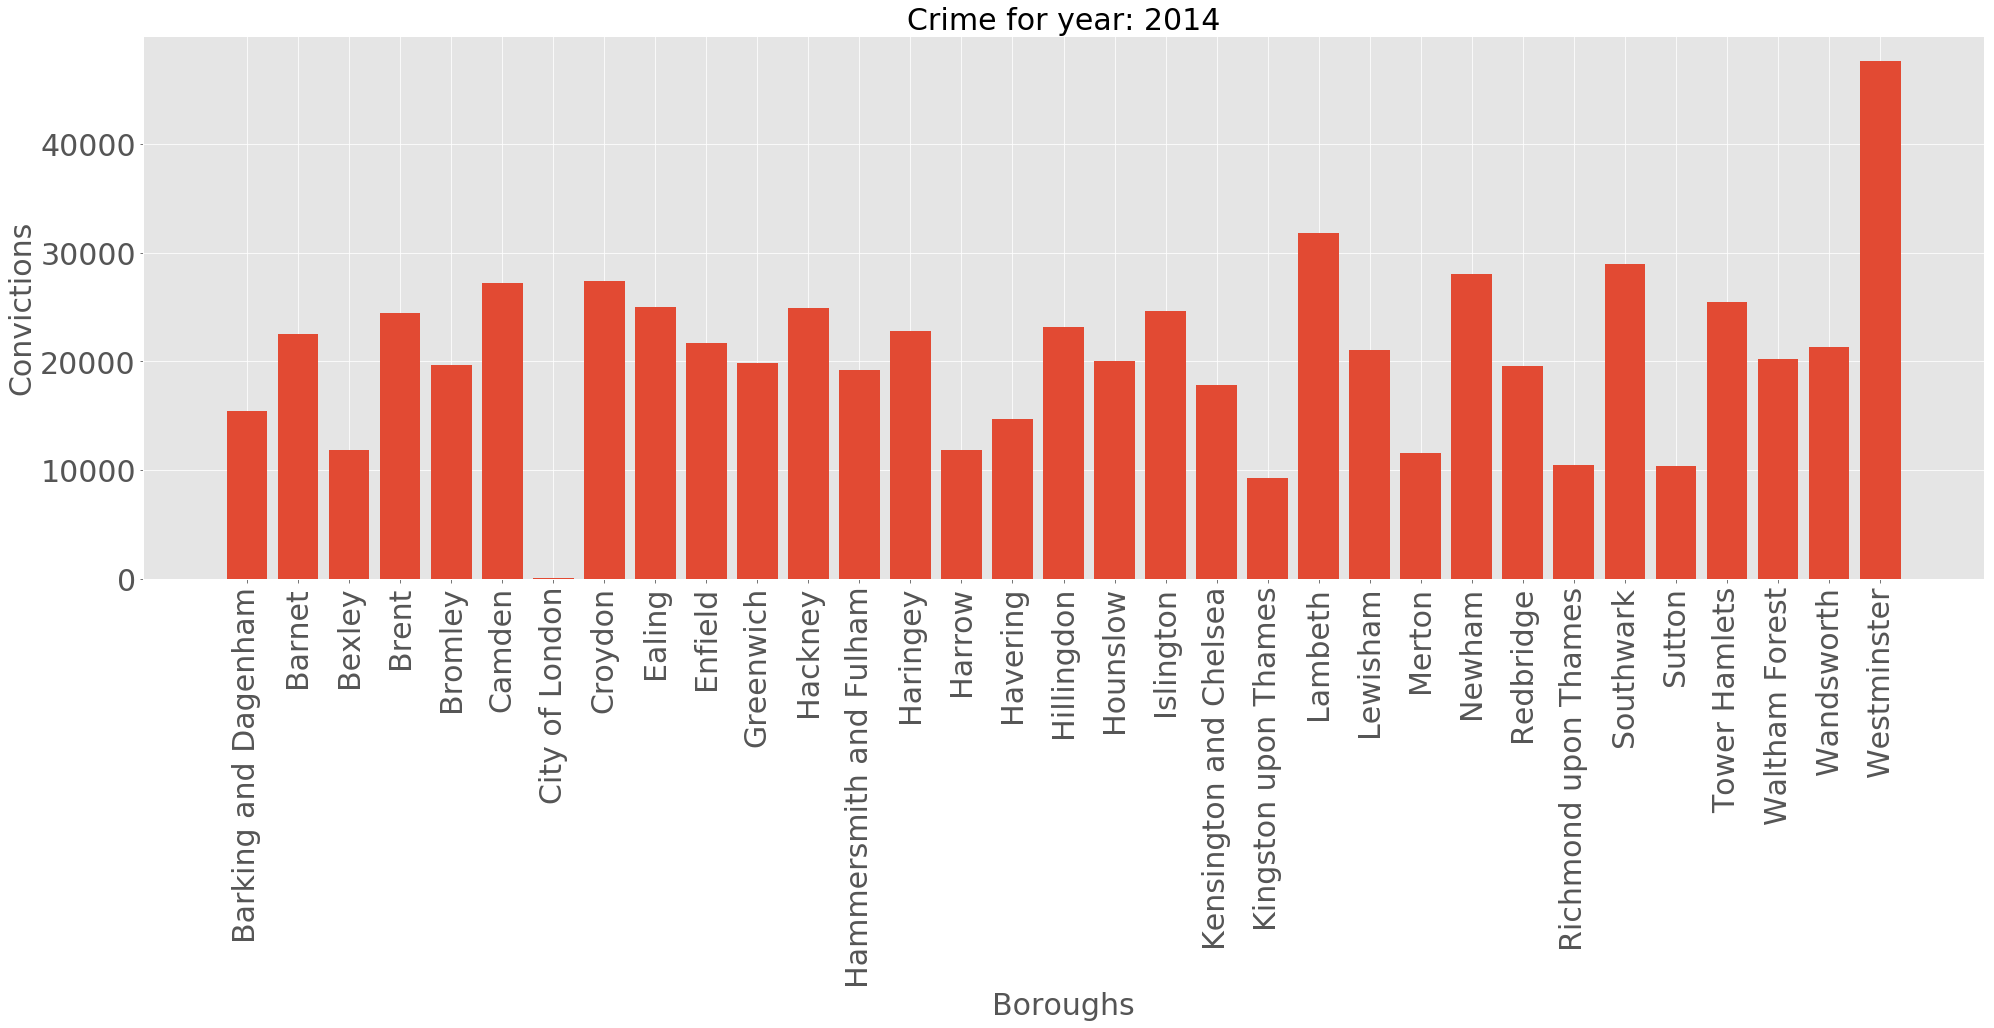

In [93]:
describe_year('2014')